In [84]:
from tkinter import *
import tkinter
from tkinter import filedialog
import numpy as np
from tkinter import simpledialog
from tkinter import ttk
from tkinter.filedialog import askopenfilename
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Convolution2D
from keras.models import Sequential
from keras.models import model_from_json
import pickle


In [85]:
main = tkinter.Tk()
main.title("Depression Detection using EEG") #designing main screen
main.geometry("1000x650")


''

In [86]:
global dataset, X, Y, classifier
global X_train, X_test, y_train, y_test
global accuracy, precision, recall, fscore, cnn


In [87]:

def loadDataset():
    global dataset
    filename = filedialog.askopenfilename(initialdir=r"C:\Users\bussa\Downloads\wetransfer_depression-zip_2024-08-26_1114\depression\depression\DepressionDetection\DepressionDetection\Dataset")
    text.delete('1.0', END)
    text.insert(END,filename+" loaded\n\n");
    dataset = pd.read_csv(filename)
    dataset.Label[dataset.Label == 2.0] = 1.0 
    label = dataset.groupby('Label').size()
    label.plot(kind="bar")
    plt.title("Total Normal & Depressed Records found in dataset 0 (Normal) & 1 (Depressed)")
    plt.show()


In [88]:
def featuresExtraction():
    global dataset, X, Y
    global X_train, X_test, y_train, y_test
    text.delete('1.0', END)
    dataset.fillna(0, inplace = True)
    dataset = dataset.values
    X = dataset[:,0:dataset.shape[1]-1]
    Y = dataset[:,dataset.shape[1]-1]
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    print(Y)
    text.insert(END,"Extracted Features from EEG Signals\n\n")
    text.insert(END, str(X)+"\n\n")
    text.insert(END,"Total features found in each records : "+str(X.shape[1])+"\n")
    text.insert(END,"Total records found in dataset : "+str(X.shape[0])+"\n\n")
    text.insert(END,"Dataset Train & Test Split Details. 80% dataset used for training & 20% dataset used for testing\n\n")

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    text.insert(END,"Total records used to train algorithms are : "+str(X_train.shape[0])+"\n")
    text.insert(END,"Total records used to test algorithms are  : "+str(X_test.shape[0])+"\n")


In [89]:
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100  
    conf_matrix = confusion_matrix(testY, predict) 
    text.insert(END,algorithm+' Accuracy    : '+str(a)+"\n")
    text.insert(END,algorithm+' Precision   : '+str(p)+"\n")
    text.insert(END,algorithm+' Recall      : '+str(r)+"\n")
    text.insert(END,algorithm+' FScore      : '+str(f)+"\n\n")
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    labels = ['Normal', 'Depressed']
    plt.figure(figsize =(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,2])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    

def runSVM():
    global X_train, X_test, y_train, y_test
    global accuracy, precision, recall, fscore
    accuracy = []
    precision = []
    recall = []
    fscore = []
    text.delete('1.0', END)
    svm_cls = SVC()
    svm_cls.fit(X_train, y_train)
    predict = svm_cls.predict(X_test) 
    calculateMetrics("SVM", predict, y_test)


In [90]:
def runCNN():
    text.delete('1.0', END)
    global X_train, X_test, y_train, y_test, X, Y, cnn
    global accuracy, precision, recall, fscore

    # Reshape and preprocess the data
    X = X[:, 0:972]
    XX = X.reshape(X.shape[0], 18, 18, 3)
    YY = to_categorical(Y)
    print(XX.shape)

    # Split data into training and testing sets
    X_train1, X_test1, y_train1, y_test1 = train_test_split(XX, YY, test_size=0.2)

    # Check if the model exists
    if os.path.exists('model.json'):
        with open('model.json', "r") as json_file:
            loaded_model_json = json_file.read()
            cnn = model_from_json(loaded_model_json)
        cnn.load_weights("model_weights.h5")
    else:
        # Build the CNN model
        cnn = Sequential()
        cnn.add(Conv2D(32, (3, 3), input_shape=(X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation='relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2)))
        cnn.add(Conv2D(32, (3, 3), activation='relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2)))
        cnn.add(Flatten())
        cnn.add(Dense(units=256, activation='relu'))
        cnn.add(Dense(units=y_test1.shape[1], activation='softmax'))
        cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model
        hist = cnn.fit(X_train1, y_train1, batch_size=16, epochs=10, shuffle=True, verbose=2, validation_data=(X_test1, y_test1))
        
        # Save model weights and architecture
        cnn.save_weights('model_weights.weights.h5')
        model_json = cnn.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        
        # Save training history
        with open('history.pckl', 'wb') as f:
            pickle.dump(hist.history, f)

    print(cnn.summary())

    # Predict and calculate metrics
    predict = cnn.predict(X_test1)
    predict = np.argmax(predict, axis=1)
    testY = np.argmax(y_test1, axis=1)
    calculateMetrics("CNN", predict, testY)


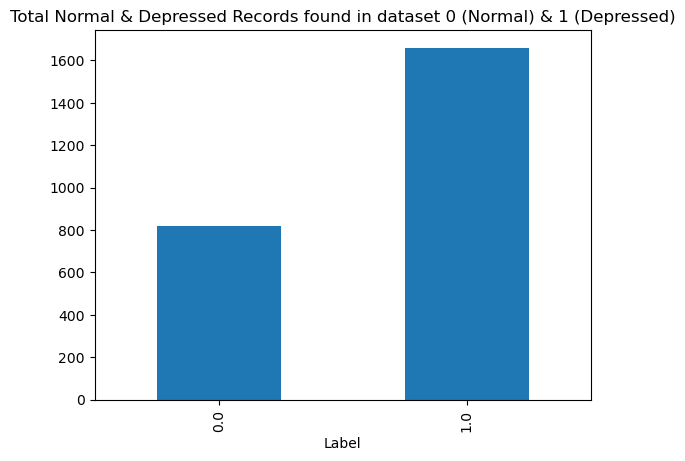

[1. 0. 0. ... 1. 1. 1.]


C:\Users\bussa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


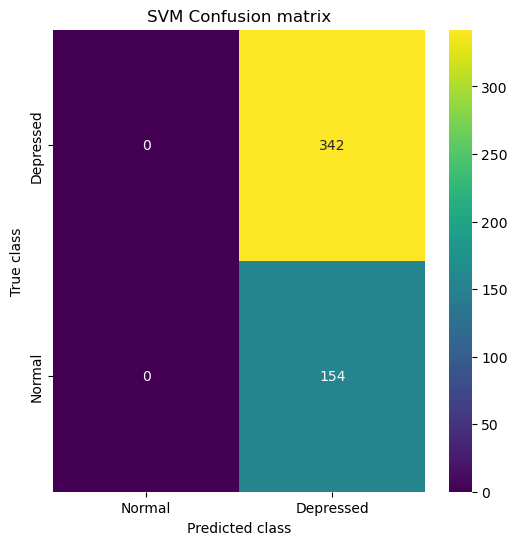

(2479, 18, 18, 3)
Epoch 1/10


C:\Users\bussa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


124/124 - 2s - 16ms/step - accuracy: 0.7665 - loss: 20.9849 - val_accuracy: 0.8367 - val_loss: 0.9044
Epoch 2/10
124/124 - 0s - 4ms/step - accuracy: 0.8578 - loss: 0.7577 - val_accuracy: 0.8770 - val_loss: 0.4953
Epoch 3/10
124/124 - 0s - 4ms/step - accuracy: 0.8810 - loss: 0.5531 - val_accuracy: 0.9052 - val_loss: 0.5395
Epoch 4/10
124/124 - 0s - 4ms/step - accuracy: 0.9062 - loss: 0.5342 - val_accuracy: 0.8266 - val_loss: 0.8245
Epoch 5/10
124/124 - 0s - 4ms/step - accuracy: 0.7827 - loss: 4.9331 - val_accuracy: 0.8085 - val_loss: 0.9423
Epoch 6/10
124/124 - 0s - 4ms/step - accuracy: 0.8538 - loss: 1.4751 - val_accuracy: 0.8871 - val_loss: 0.6920
Epoch 7/10
124/124 - 0s - 4ms/step - accuracy: 0.9007 - loss: 0.5975 - val_accuracy: 0.8891 - val_loss: 1.0184
Epoch 8/10
124/124 - 0s - 4ms/step - accuracy: 0.8931 - loss: 0.9928 - val_accuracy: 0.8810 - val_loss: 0.5248
Epoch 9/10
124/124 - 0s - 4ms/step - accuracy: 0.9395 - loss: 0.3437 - val_accuracy: 0.9577 - val_loss: 0.1623
Epoch 10/1

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 16, 16, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 6, 6, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253,928 (991.91 KB)

 Trainable params: 84,642 (330.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,286 (661.28 KB)

None
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


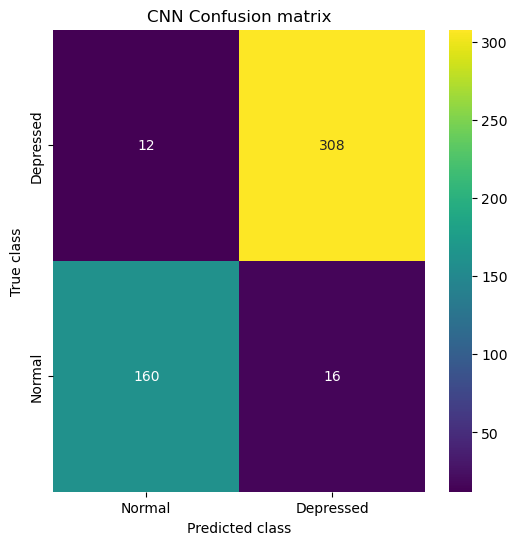

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[1 1 0 1 0 1 1]


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\bussa\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\bussa\AppData\Local\Temp\ipykernel_9440\1462613457.py", line 22, in graph
    df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given


(2479, 18, 18, 3)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 16, 16, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 6, 6, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253,928 (991.91 KB)

 Trainable params: 84,642 (330.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,286 (661.28 KB)

None
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


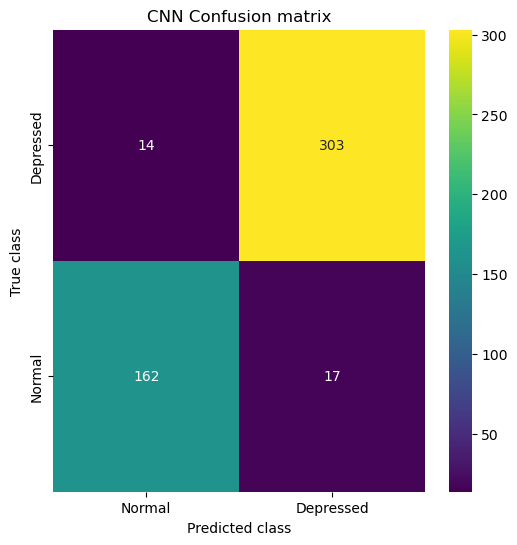

In [91]:
def predictDepression():
    global cnn
    labels = ["Normal", "Depressed"]
    filename = filedialog.askopenfilename(initialdir="Dataset")
    text.delete('1.0', END)
    text.insert(END,filename+" loaded\n\n");
    dataset = pd.read_csv(filename)
    dataset = dataset.values
    testData = dataset[:,0:972]
    test_X = testData.reshape(testData.shape[0], 18, 18, 3)
    predict = cnn.predict(test_X)
    predict = np.argmax(predict, axis=1)
    print(predict)
    for i in range(len(testData)):
        text.insert(END,str(testData[i])+" PREDICTED AS ====> "+labels[predict[i]]+"\n\n")

def graph():
    df = pd.DataFrame([['SVM','Precision',precision[0]],['SVM','Recall',recall[0]],['SVM','F1 Score',fscore[0]],['SVM','Accuracy',accuracy[0]],
                       ['CNN','Precision',precision[0]],['CNN','Recall',recall[0]],['CNN','F1 Score',fscore[0]],['CNN','Accuracy',accuracy[0]],
                       
                      ],columns=['Parameters','Algorithms','Value'])
    df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
    plt.title("Existing SVM & Propose CNN Performance Graph")
    plt.show()

def close():
    main.destroy()

font = ('times', 16, 'bold')
title = Label(main, text='Depression Detection using EEG', justify=LEFT)
title.config(bg='lavender blush', fg='DarkOrchid1')  
title.config(font=font)           
title.config(height=3, width=120)       
title.place(x=100,y=5)
title.pack()

font1 = ('times', 13, 'bold')
uploadButton = Button(main, text="Upload EEG-Signal Dataset", command=loadDataset)
uploadButton.place(x=10,y=100)
uploadButton.config(font=font1)

featuresButton = Button(main, text="Features Extraction", command=featuresExtraction)
featuresButton.place(x=330,y=100)
featuresButton.config(font=font1) 

svmButton = Button(main, text="Run Existing SVM Algorithm", command=runSVM)
svmButton.place(x=680,y=100)
svmButton.config(font=font1) 

cnnButton = Button(main, text="Run Propose CNN Algorithm", command=runCNN)
cnnButton.place(x=10,y=150)
cnnButton.config(font=font1)

predictButton = Button(main, text="Predict Depression from Test Signals", command=predictDepression)
predictButton.place(x=330,y=150)
predictButton.config(font=font1)

graphButton = Button(main, text="Comparison Graph", command=graph)
graphButton.place(x=680,y=150)
graphButton.config(font=font1)

closeButton = Button(main, text="Exit", command=close)
closeButton.place(x=880,y=150)
closeButton.config(font=font1)


font1 = ('times', 12, 'bold')
text=Text(main,height=20,width=120)
scroll=Scrollbar(text)
text.configure(yscrollcommand=scroll.set)
text.place(x=10,y=200)
text.config(font=font1)

main.config(bg='light coral')
main.mainloop()
